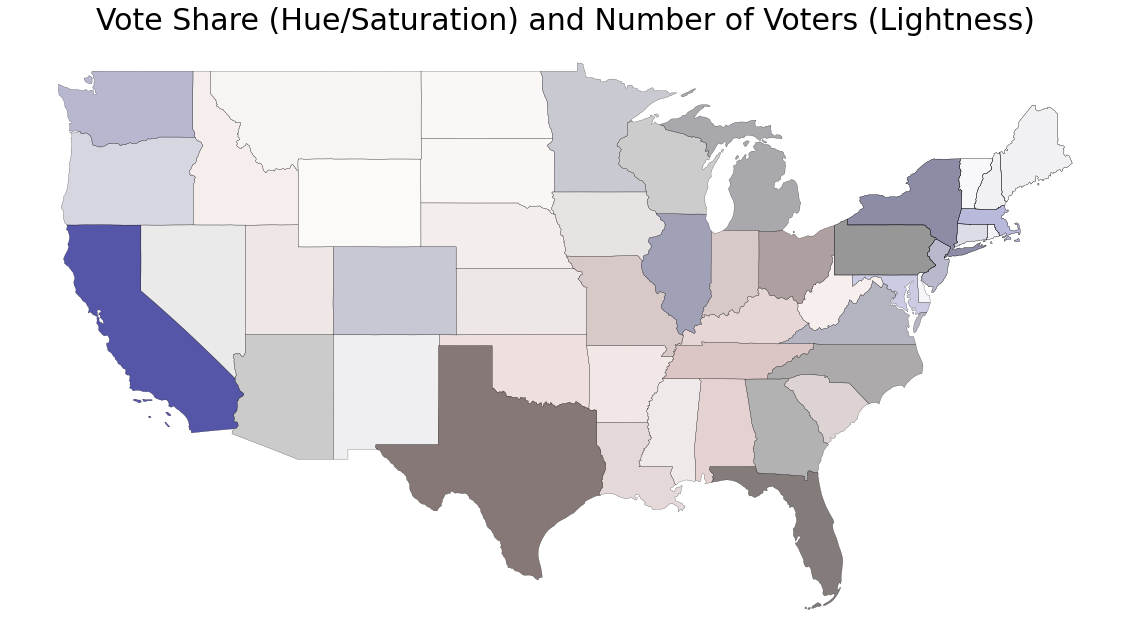

In [4]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex


def get_json():
    return requests.get('https://static01.nyt.com/elections-assets/2020/data/api/2020-11-03/votes-remaining-page/national/president.json').json()


def parse_json(json_request):
    parsed_dict = {}
    for state in json_request["data"]["races"]:
        candidates = state['candidates']
        state_results_dict = {}
        for candidate in candidates:
            if candidate['last_name']=='Trump':
                state_results_dict['Trump'] = candidate['votes']
            if candidate['last_name']=='Biden':
                state_results_dict['Biden'] = candidate['votes']
        parsed_dict[state['state_name']] = state_results_dict

    return parsed_dict


def make_df(data_dict):
    drop_cols = ['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'LSAD', 'ALAND', 'AWATER']

    election_df = pd.DataFrame(data_dict).T
    election_df['NAME'] = election_df.index
    states = gpd.read_file('data/usa-states-census-2014.shp')
    states = states.drop_duplicates()
    election_df = states.merge(election_df, on='NAME')
    election_df = election_df.drop(drop_cols, axis=1)
    election_df['Vote Total'] = election_df['Biden'] + election_df['Trump']
    upper_fence = (np.quantile(election_df['Vote Total'], .75) + 1.5*(np.quantile(election_df['Vote Total'], .75) -
     np.quantile(election_df['Vote Total'], .25)))
    election_df['Relative Vote Total'] = election_df['Vote Total']/upper_fence
    election_df['Relative Vote Total'] = election_df['Relative Vote Total'].apply(lambda x: min(1, x))
    election_df['Pct Biden'] = election_df['Biden']/election_df['Vote Total']
    election_df['Pct Trump'] = election_df['Trump']/election_df['Vote Total']
    election_df.columns = ['State Code', 'State Name', 'Region', 'geometry', 'Biden', 'Trump', 'Vote Total', 'Relative Vote Total',
        'Pct Biden', 'Pct Trump']
    return election_df

def make_rgb_cols(df):
    df['b'] = df.apply(lambda x: x['Pct Biden'], axis=1)
    df['r'] = df.apply(lambda x: x['Pct Trump'], axis=1)
    df['g'] = df.apply(lambda x: min(x['b'], x['r']), axis=1)
    df['rgb'] = df.apply(lambda x: (x['r'], x['g'], x['b']), axis=1)
    df['rgb'] = df.apply(lambda x: (x['r'], x['g'], x['b'], x['Relative Vote Total']), axis=1)
    return df

def plotter(df, save=False):
    fig, ax = plt.subplots(figsize=(20, 20))
    fig.set_facecolor('w')
    plt.axis('off')
    plt.title('Vote Share (Hue/Saturation) and Number of Voters (Lightness)', fontsize=30)
    ax.set_aspect('equal')
    base = df.plot(color=df['rgb'], ax=ax)
    state_shapes = gpd.read_file('data/usa-states-census-2014.shp')
    state_shapes.plot(ax=base, facecolor="none", edgecolor="black", linewidth=.2)
    if save: fig.savefig('maps/state_muddy_map.png', dpi=fig.dpi, bbox_inches = 'tight')
    plt.show()

def main():
    data_dict = parse_json(get_json())
    election_df = make_df(data_dict)
    election_df = make_rgb_cols(election_df)
    plotter(election_df, save=True)

if __name__ == '__main__':
    main()